# Import Data:

In [1]:
%pip install scikit-learn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pickle
import numpy as np
import gc

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS = 950

# Load the pickle file
print("Loading datafile...")
with open("../mon_standard.pkl", 'rb') as fi:
    data = pickle.load(fi)

# Determine the total number of samples and the maximum sequence length
num_samples = sum(len(data[i]) for i in range(TOTAL_URLS))
max_length = max(len(sample) for i in range(TOTAL_URLS) for sample in data[i])

X1_mon = []
X2_mon = []
y_mon = []

for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE

    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)

        X1_mon.append(time_seq)
        X2_mon.append(size_seq)
        y_mon.append(label)

print(f'Total samples: {len(y_mon)}')
# Convert to numpy arrays directly
X1_mon = np.array(X1_mon, dtype=object)
X2_mon = np.array(X2_mon, dtype=object)
y_mon = np.array(y_mon, dtype=int)

Loading datafile...
Total samples: 19000


In [2]:
import pickle

TOTAL_URLS = 10000  # total number in the dataset

# Load 10,000 unmon pickle file
print("Loading datafile...")
with open('../unmon_standard10.pkl', 'rb') as f:  # Path to unmon_standard10.pkl in Colab
    x = pickle.load(f)

size = len(x)
print(f'Total samples: {size}')

X1_unmon = [] # Array to store instances (timestamps) - 10,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2_unmon = [] # Array to store instances (direction*size) - size information

for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
    X1_unmon.append(time_seq)
    X2_unmon.append(size_seq)

# Convert to numpy arrays directly
X1_unmon = np.array(X1_unmon, dtype=object)
X2_unmon = np.array(X2_unmon, dtype=object)

print(len(X1_unmon)) # Print the length of X1

Loading datafile...
Total samples: 10000
10000


## Data Preparation

In [ ]:
import statistics

# Packet Direction and Size Analysis
incoming_packet_count = [sum(1 for size in sub_array if size < 0) for sub_array in X2_mon]  # Incoming Packet Count
outgoing_packet_count = [sum(1 for size in sub_array if size > 0) for sub_array in X2_mon]  # Outgoing Packet Count
total_packet_count = [len(sub_array) for sub_array in X2_mon]  # Total Packet Count
fraction_incoming_packets = [incoming / len(sub_array) if len(sub_array) != 0 else 0 for incoming, sub_array in zip(incoming_packet_count, X2_mon)]  # Fraction of Incoming Packets
fraction_outgoing_packets = [outgoing / len(sub_array) if len(sub_array) != 0 else 0 for outgoing, sub_array in zip(outgoing_packet_count, X2_mon)]  # Fraction of Outgoing Packets

# Packet Ordering Statistics
avg_incoming_packet_order = [np.mean([i for i, size in enumerate(sub_array) if size < 0]) if any(size < 0 for size in sub_array) else 0 for sub_array in X2_mon]  # Avg. Incoming Packet Order
std_dev_incoming_packet_order = [np.std([i for i, size in enumerate(sub_array) if size < 0]) if any(size < 0 for size in sub_array) else 0 for sub_array in X2_mon]  # Std. Dev. Incoming Packet Order
avg_outgoing_packet_order = [np.mean([i for i, size in enumerate(sub_array) if size > 0]) if any(size > 0 for size in sub_array) else 0 for sub_array in X2_mon]  # Avg. Outgoing Packet Order
std_dev_outgoing_packet_order = [np.std([i for i, size in enumerate(sub_array) if size > 0]) if any(size > 0 for size in sub_array) else 0 for sub_array in X2_mon]  # Std. Dev. Outgoing Packet Order

# Packet Concentration and Inter-Arrival Times
packet_concentration = [np.mean(np.diff(time_seq)) if len(time_seq) > 1 else 0 for time_seq in X1_mon]  # Mean Packet Concentration
incoming_inter_arrival_stats = []
outgoing_inter_arrival_stats = []
for time_seq, size_seq in zip(X1_mon, X2_mon):
    if len(time_seq) > 1:
        incoming_times = [time for time, size in zip(time_seq, size_seq) if size < 0]
        outgoing_times = [time for time, size in zip(time_seq, size_seq) if size > 0]
        if incoming_times:
            incoming_diffs = np.diff(incoming_times)
            incoming_inter_arrival_stats.append([np.max(incoming_diffs), np.mean(incoming_diffs), np.std(incoming_diffs), np.percentile(incoming_diffs, 75)])
        else:
            incoming_inter_arrival_stats.append([0, 0, 0, 0])
        if outgoing_times:
            outgoing_diffs = np.diff(outgoing_times)
            outgoing_inter_arrival_stats.append([np.max(outgoing_diffs), np.mean(outgoing_diffs), np.std(outgoing_diffs), np.percentile(outgoing_diffs, 75)])
        else:
            outgoing_inter_arrival_stats.append([0, 0, 0, 0])
    else:
        incoming_inter_arrival_stats.append([0, 0, 0, 0])
        outgoing_inter_arrival_stats.append([0, 0, 0, 0])
incoming_max_inter_arrival_time, incoming_mean_inter_arrival_time, incoming_std_inter_arrival_time, incoming_third_quartile_inter_arrival_time = zip(*incoming_inter_arrival_stats)
outgoing_max_inter_arrival_time, outgoing_mean_inter_arrival_time, outgoing_std_inter_arrival_time, outgoing_third_quartile_inter_arrival_time = zip(*outgoing_inter_arrival_stats)

# Transmission Time Analysis
transmission_time_stats = [[np.percentile(time_seq, q) for q in [25, 50, 75, 100]] for time_seq in X1_mon]  # Quartiles of Transmission Times
transmission_time_Q1, transmission_time_Q2, transmission_time_Q3, transmission_time_Q4 = zip(*transmission_time_stats)

# Packet Count in First 30
incoming_packets_first30 = [sum(1 for size in sub_array[:30] if size < 0) for sub_array in X2_mon]  # Incoming Packets in First 30
outgoing_packets_first30 = [sum(1 for size in sub_array[:30] if size > 0) for sub_array in X2_mon]  # Outgoing Packets in First 30

# Packet Per Second Analysis
packets_per_second_stats = [[np.mean(np.diff(time_seq)), np.std(np.diff(time_seq)), np.median(np.diff(time_seq))] if len(time_seq) > 1 else [0, 0, 0] for time_seq in X1_mon]
mean_packets_per_second, std_packets_per_second, median_packets_per_second = zip(*packets_per_second_stats)

# Alternative Packets Per Second Sum
alternative_packets_per_second_sum = [sum(np.diff(time_seq)) for time_seq in X1_mon]  # Alternative Packets Per Second Sum
combined_counts = [incoming + outgoing + total for incoming, outgoing, total in zip(incoming_packet_count, outgoing_packet_count, total_packet_count)]

# Additional Features
sum_packet_sizes = [sum(abs(size) for size in sub_array) for sub_array in X2_mon]  # Sum of Packet Sizes
mean_sequence_value = [np.mean(sub_array) for sub_array in X2_mon]  # Mean of the Sequence

max_packet_size = [max(sub_array, default=0) for sub_array in X2_mon]  # Max Packet Size for each time series

average_packet_size = [np.mean([abs(size) for size in sub_array]) if sub_array else 0 for sub_array in X2_mon]  # Average Packet Size for each time series
peak_to_average_packet_ratio = [max_size / avg_size if avg_size != 0 else 0 for max_size, avg_size in zip(max_packet_size, average_packet_size)]  # Peak to Average Packet Ratio for each time series

max_time_interval = [max(np.diff(time_seq), default=0) for time_seq in X1_mon]  # Max Time Interval for each time series

std_dev_transmission_times = [np.std(np.diff(time_seq)) if len(time_seq) > 1 else 0 for time_seq in X1_mon]

small_packet_threshold = 513  # Define the threshold for small packets
percentage_small_packets = [sum(1 for size in sub_array if abs(size) < small_packet_threshold) / len(sub_array) * 100 if sub_array else 0 for sub_array in X2_mon]  # Percentage of Small Packets for each time series


In [ ]:
feature_names = [
    "Incoming Packet Count",
    "Outgoing Packet Count",
    "Total Packet Count",
    "Fraction of Incoming Packets",
    "Fraction of Outgoing Packets",
    "Average Incoming Packet Order",
    "Standard Deviation of Incoming Packet Order",
    "Average Outgoing Packet Order",
    "Standard Deviation of Outgoing Packet Order",
    "Mean Packet Concentration",
    "Maximum Incoming Inter-Arrival Time",
    "Mean Incoming Inter-Arrival Time",
    "Standard Deviation of Incoming Inter-Arrival Time",
    #"Third Quartile of Incoming Inter-Arrival Time",
    "Maximum Outgoing Inter-Arrival Time",
    "Mean Outgoing Inter-Arrival Time",
    "Standard Deviation of Outgoing Inter-Arrival Time",
    "Third Quartile of Outgoing Inter-Arrival Time",
    "First Quartile of Transmission Time",
    "Second Quartile of Transmission Time",
    "Third Quartile of Transmission Time",
    "Fourth Quartile of Transmission Time",
    "Incoming Packets in First 30",
    "Outgoing Packets in First 30",
    "Mean Packets Per Second",
    "Standard Deviation of Packets Per Second",
    #"Median Packets Per Second",
    "Alternative Packets Per Second Sum",
    "Combined Packet Count",
    "Sum of Packet Sizes",
    "Mean of Packet Sizes",
    #"Maximum Packet Size",
    #"Peak to Average Packet Size Ratio",
    "Maximum Time Interval",
    "Standard Deviation of Transmission Times",
    #"Percentage of Small Packets"
]

X_mon_features = np.column_stack((
    incoming_packet_count,
    outgoing_packet_count,
    total_packet_count,
    fraction_incoming_packets,
    fraction_outgoing_packets,
    avg_incoming_packet_order,
    std_dev_incoming_packet_order,
    avg_outgoing_packet_order,
    std_dev_outgoing_packet_order,
    packet_concentration,
    incoming_max_inter_arrival_time,
    incoming_mean_inter_arrival_time,
    incoming_std_inter_arrival_time,
    #incoming_third_quartile_inter_arrival_time,
    outgoing_max_inter_arrival_time,
    outgoing_mean_inter_arrival_time,
    outgoing_std_inter_arrival_time,
    outgoing_third_quartile_inter_arrival_time,
    transmission_time_Q1,
    transmission_time_Q2,
    transmission_time_Q3,
    transmission_time_Q4,
    incoming_packets_first30,
    outgoing_packets_first30,
    mean_packets_per_second,
    std_packets_per_second,
    #median_packets_per_second,
    alternative_packets_per_second_sum,
    combined_counts,
    sum_packet_sizes,
    mean_sequence_value,
    #max_packet_size,
    #peak_to_average_packet_ratio,
    max_time_interval,
    std_dev_transmission_times,
    #percentage_small_packets
))

Feature: Incoming Packet Count, Score: 0.04059
Feature: Outgoing Packet Count, Score: 0.05073
Feature: Total Packet Count, Score: 0.03921
Feature: Fraction of Incoming Packets, Score: 0.04657
Feature: Fraction of Outgoing Packets, Score: 0.04676
Feature: Average Incoming Packet Order, Score: 0.04230
Feature: Standard Deviation of Incoming Packet Order, Score: 0.04354
Feature: Average Outgoing Packet Order, Score: 0.05422
Feature: Standard Deviation of Outgoing Packet Order, Score: 0.05052
Feature: Mean Packet Concentration, Score: 0.02045
Feature: Maximum Incoming Inter-Arrival Time, Score: 0.03252
Feature: Mean Incoming Inter-Arrival Time, Score: 0.02402
Feature: Standard Deviation of Incoming Inter-Arrival Time, Score: 0.02805
Feature: Maximum Outgoing Inter-Arrival Time, Score: 0.02429
Feature: Mean Outgoing Inter-Arrival Time, Score: 0.02508
Feature: Standard Deviation of Outgoing Inter-Arrival Time, Score: 0.02404
Feature: Third Quartile of Outgoing Inter-Arrival Time, Score: 0.01

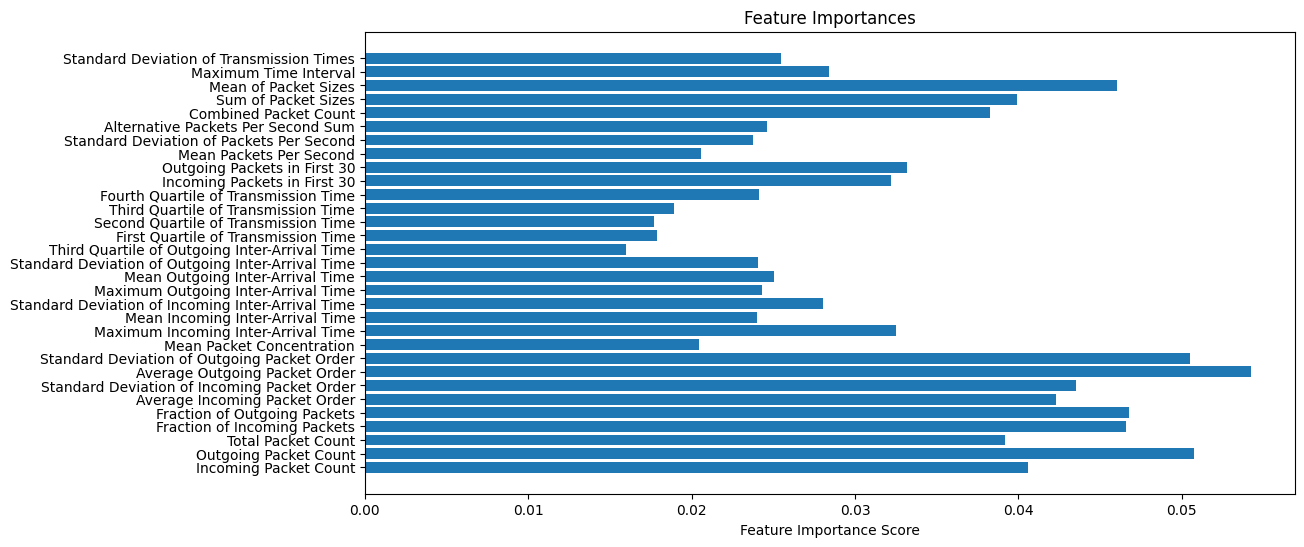

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mon_features, y_mon, test_size=0.3, random_state=42)

# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_clf.fit(X_train, y_train)

# Get feature importances
importances = rf_clf.feature_importances_

for i,v in enumerate(importances):
    print('Feature: %s, Score: %.5f' % (feature_names[i],v))

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xlabel('Feature Importance Score')
plt.title('Feature Importances')
plt.show()

## Naive Bayes

Original number of features: 31, Reduced number of features: 8
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Accuracy: 0.1879
Best Params: {'var_smoothing': 6.579332246575683e-06}

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.13      0.41      0.19        59
           2       0.25      0.05      0.09        55
           3       0.00      0.00      0.00        46
           4       0.00      0.00      0.00        53
           5       0.08      0.06      0.07        63
           6       0.28      0.28      0.28        65
           7       0.19      0.33      0.24        64
           8       0.41      0.15      0.22        59
           9       0.14      0.19      0.16        47
          10       0.42      0.08      0.13        66
          11       0.15      0.07      0.10        57
          12       0.52      0.22      0.31        59
          13       0.

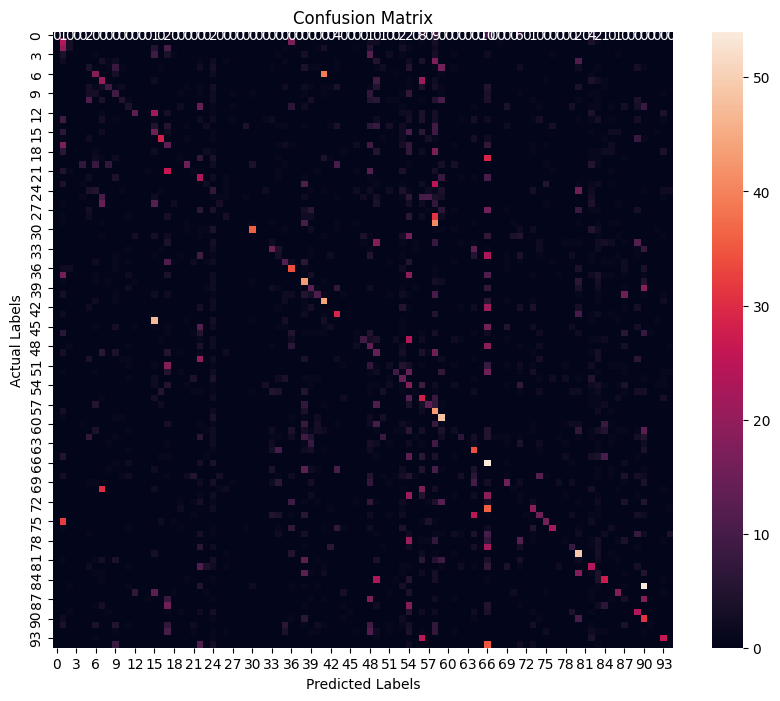

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Assuming X_categorical and y are your features and labels respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mon_features, y_mon, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
# Choose the number of components to explain a certain percentage of variance, e.g., 95%
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original number of features: {X_train_scaled.shape[1]}, Reduced number of features: {X_train_pca.shape[1]}")

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Setting up the grid search
params = {
    'var_smoothing': np.logspace(0, -9, num=100)
}
grid_search = GridSearchCV(estimator=gnb, param_grid=params, cv=5, verbose=1, scoring='accuracy')

# Train the classifier with grid search
grid_search.fit(X_train_pca, y_train)

# Best estimator found by grid search
best_clf = grid_search.best_estimator_

# Make predictions with the best classifier
y_pred = best_clf.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(f'Best Params: {grid_search.best_params_}')

# Generate a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

## SVM:

Accuracy: 0.6526

Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.45      0.47        62
           1       0.64      0.54      0.59        59
           2       0.59      0.75      0.66        55
           3       0.48      0.65      0.56        46
           4       0.58      0.75      0.66        53
           5       0.69      0.63      0.66        63
           6       0.73      0.85      0.79        65
           7       0.73      0.62      0.67        64
           8       0.73      0.64      0.68        59
           9       0.53      0.64      0.58        47
          10       0.75      0.70      0.72        66
          11       0.59      0.72      0.65        57
          12       0.82      0.80      0.81        59
          13       0.38      0.41      0.39        54
          14       0.54      0.53      0.54        58
          15       0.61      0.68      0.64        59
          16       0.67      0.62      

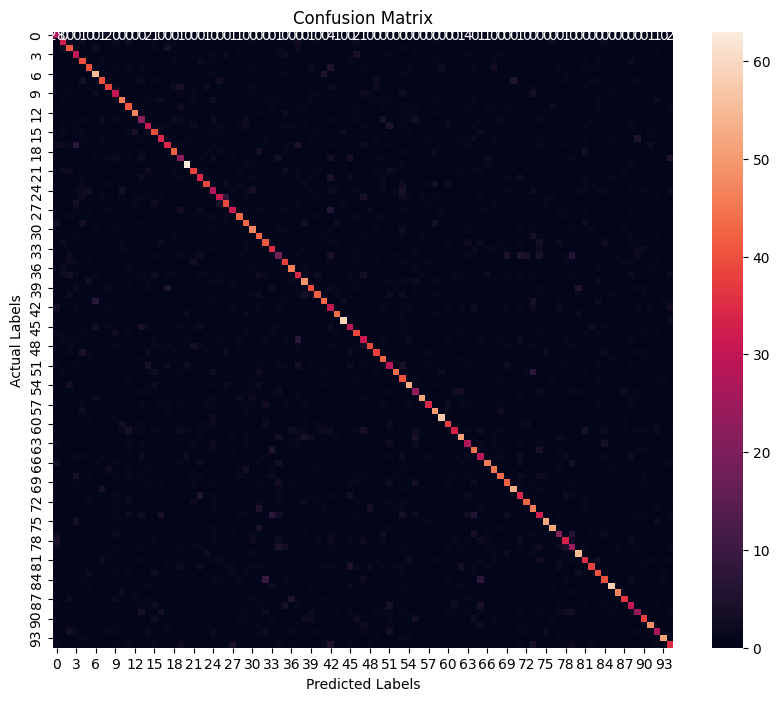

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_mon_features and y_mon are your features and labels respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mon_features, y_mon, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

svm_clf = SVC(kernel='rbf', C=1000, gamma=0.1)

# Train the classifier
svm_clf.fit(X_train_pca, y_train)

# Make predictions
y_pred = svm_clf.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

## Decision Tree:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_categorical and y are your features and labels respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mon_features, y_mon, test_size=0.3, random_state=42)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Set up the grid of parameters to search
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(dt_clf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train the classifier with best parameters
best_dt_clf = grid_search.best_estimator_

# Make predictions
y_pred = best_dt_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
#print("\nClassification Report:\n")
#print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
#conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
#plt.figure(figsize=(10, 8))
#sns.heatmap(conf_matrix, annot=True, fmt='g')
#plt.title('Confusion Matrix')
#plt.ylabel('Actual Labels')
#plt.xlabel('Predicted Labels')
#plt.show()

# Visualizing the Decision Tree
#plt.figure(figsize=(20, 10))
#plot_tree(best_dt_clf, filled=True, feature_names=feature_names, class_names=True)
#plt.title('Decision Tree')
#plt.show()

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.6354


## Random Forest Classifier:

Accuracy: 0.7846

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.68      0.71        62
           1       0.82      0.63      0.71        59
           2       0.88      0.95      0.91        55
           3       0.68      0.83      0.75        46
           4       0.81      0.89      0.85        53
           5       0.90      0.84      0.87        63
           6       0.83      0.92      0.88        65
           7       0.84      0.81      0.83        64
           8       0.83      0.81      0.82        59
           9       0.67      0.72      0.69        47
          10       0.85      0.71      0.78        66
          11       0.82      0.74      0.78        57
          12       0.89      0.92      0.90        59
          13       0.63      0.44      0.52        54
          14       0.79      0.59      0.67        58
          15       0.75      0.83      0.79        59
          16       0.80      0.71      

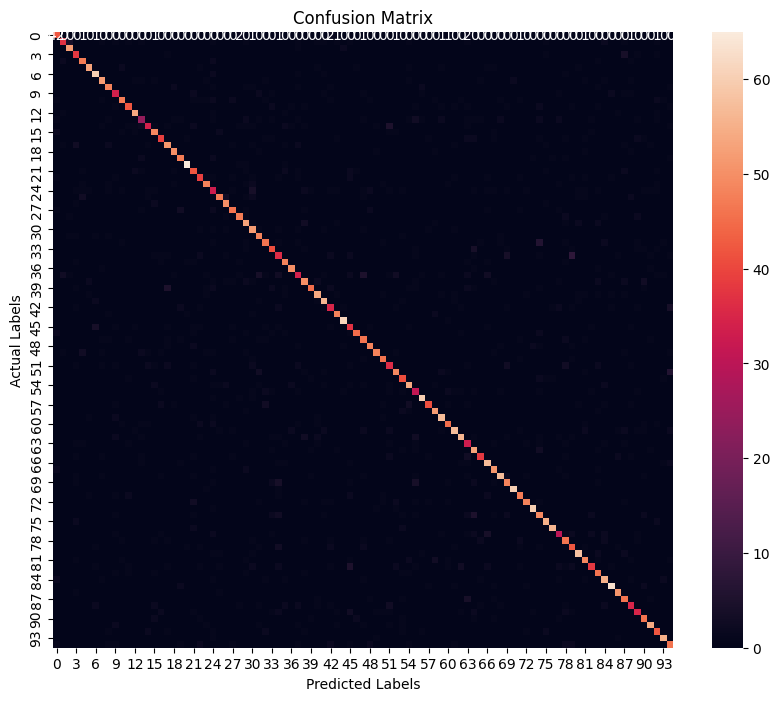

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_mon_features and y_mon are your features and labels respectively

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mon_features, y_mon, test_size=0.3, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(
    n_estimators=1000,
    criterion='entropy',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1
)

# Fit the classifier to the training data
clf.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

## k-NN Classifier:

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameter found:  {'n_neighbors': 3}
Accuracy: 0.5767

Classification Report:

              precision    recall  f1-score   support

           0       0.27      0.44      0.33        62
           1       0.50      0.58      0.54        59
           2       0.39      0.75      0.52        55
           3       0.33      0.65      0.43        46
           4       0.49      0.64      0.55        53
           5       0.47      0.65      0.55        63
           6       0.66      0.75      0.71        65
           7       0.47      0.53      0.50        64
           8       0.54      0.61      0.57        59
           9       0.36      0.57      0.45        47
          10       0.62      0.65      0.64        66
          11       0.46      0.68      0.55        57
          12       0.67      0.73      0.70        59
          13       0.29      0.43      0.35        54
          14       0.49      0.60      0.54  

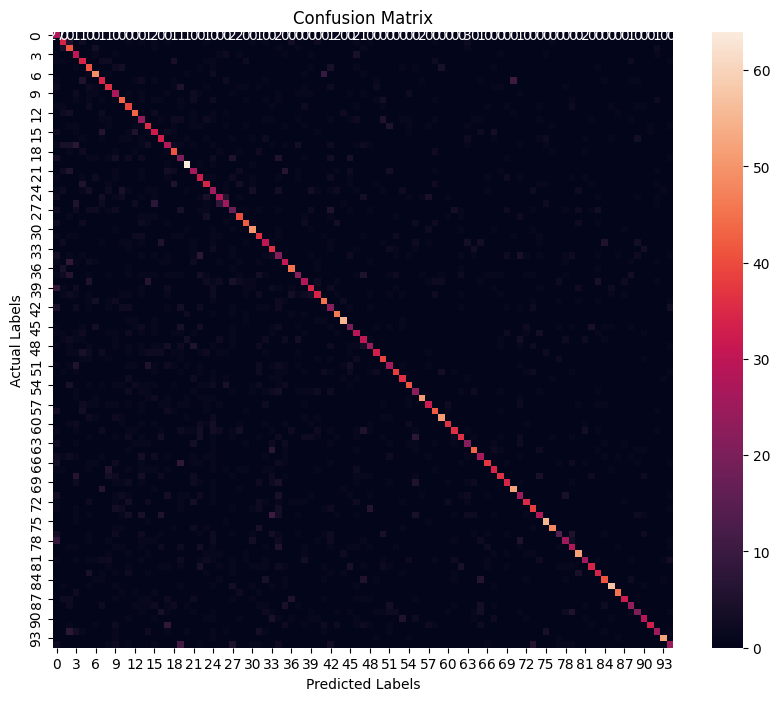

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_mon_features and y_mon are your features and labels respectively
X_train, X_test, y_train, y_test = train_test_split(X_mon_features, y_mon, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Initialize the k-NN Classifier
knn_clf = KNeighborsClassifier()

# Set up the grid of parameters to search
param_grid = {'n_neighbors': [3, 5, 7, 9, 11,]}

# Set up GridSearchCV with k-NN
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_pca, y_train)

# Best parameter found
print("Best parameter found: ", grid_search.best_params_)

# Train the classifier with the best number of neighbors
best_knn_clf = grid_search.best_estimator_
y_pred = best_knn_clf.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

## DB-Scan:

Accuracy of DBSCAN clustering: 0.2214
[[  0   0   0 ...   8   0  77]
 [  0  38  20 ...   0   0 120]
 [  0   0  47 ...   0   0  66]
 ...
 [  0   0   0 ... 147   0  53]
 [  0   0   0 ...   1   5  77]
 [  0   0   0 ...   0   0   0]]


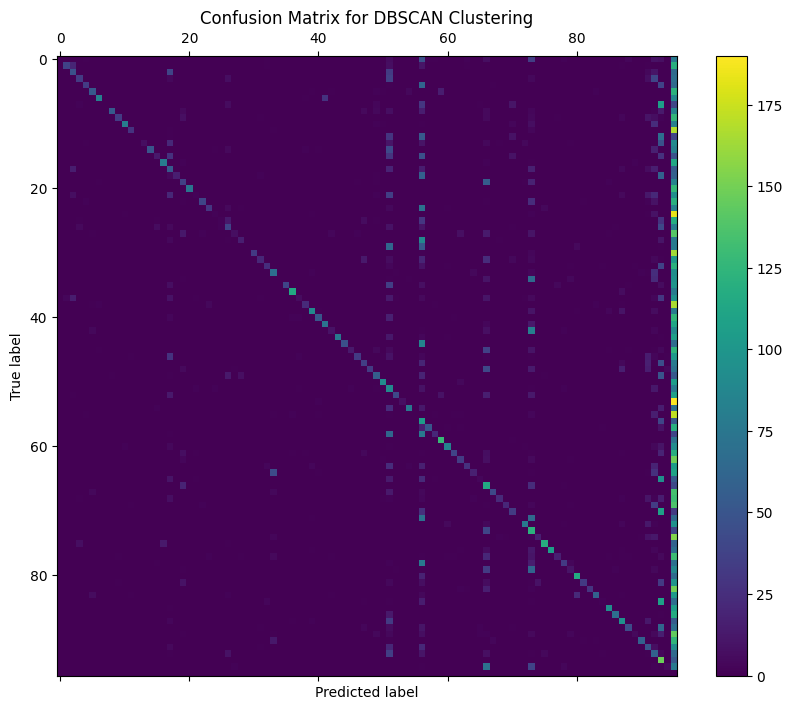

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import mode
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Feature Scaling is important for both PCA and DBSCAN
X_scaled = StandardScaler().fit_transform(X_mon_features)

# Apply PCA
pca = PCA(n_components=0.95)  # Adjust n_components as needed
X_pca = pca.fit_transform(X_scaled)

# DBSCAN Clustering on PCA-transformed data
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_pca)

# Create a label for each cluster based on the mode of the true labels in that cluster
labels_pred = np.zeros_like(clusters)
for cluster in np.unique(clusters):
    if cluster != -1:  # Ignore noise points
        mask = (clusters == cluster)
        labels_pred[mask] = mode(y_mon[mask])[0]

# Assign a unique label for noise points
noise_label = max(y_mon) + 1
labels_pred[clusters == -1] = noise_label

# Compute the accuracy of DBSCAN
accuracy = accuracy_score(y_mon, labels_pred)
print(f'Accuracy of DBSCAN clustering: {accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_mon, labels_pred)
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
plt.matshow(conf_matrix, cmap='viridis', fignum=1)
plt.title('Confusion Matrix for DBSCAN Clustering')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## k-Means:

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy of KMeans clustering: 0.2420
[[ 13   0   0 ...   0   1   0]
 [  0  79   0 ...   0   1   0]
 [  0  36   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0 114   0]
 [  0   0   0 ...   0   0   0]]


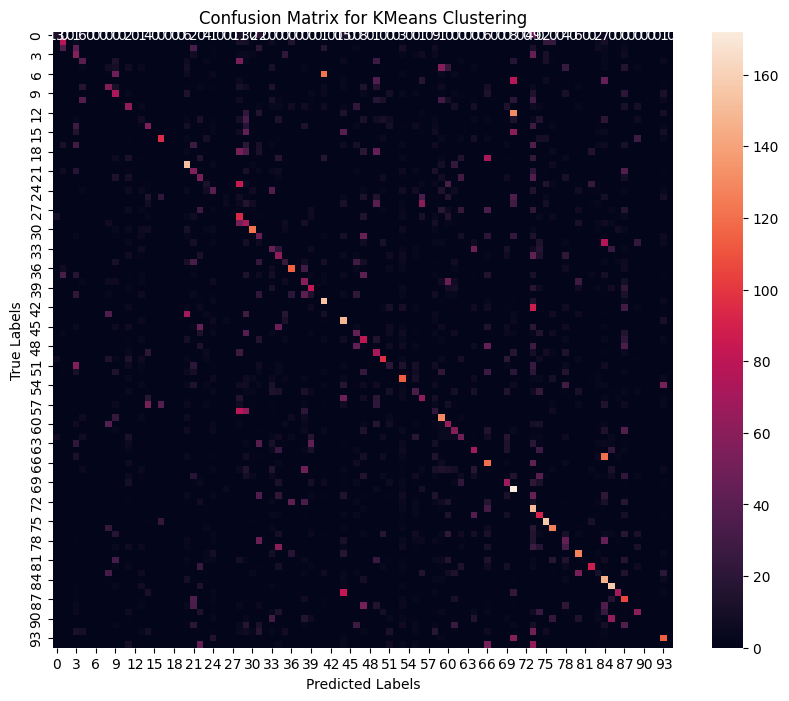

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_mon_features and y_mon are your features and labels respectively

# Determine the number of unique labels which will be our number of clusters for KMeans
n_clusters = len(np.unique(y_mon))

# Feature Scaling
X_scaled = StandardScaler().fit_transform(X_mon_features)

# Apply PCA
pca = PCA(n_components=0.975)  # Keep 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# KMeans Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Assign the most frequent true label to each cluster
labels_pred = np.zeros_like(clusters)
for cluster in np.unique(clusters):
    mask = (clusters == cluster)
    # Find the most frequent label in each cluster
    labels_pred[mask] = mode(y_mon[mask])[0]

# Compute the accuracy of KMeans
accuracy = accuracy_score(y_mon, labels_pred)
print(f'Accuracy of KMeans clustering: {accuracy:.4f}')

# Compute a confusion matrix
conf_matrix = confusion_matrix(y_mon, labels_pred)
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix for KMeans Clustering')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## Neuronal Network:

Epoch 1/150
241/241 [==============================] - 6s 16ms/step - loss: 3.5685 - accuracy: 0.1665 - val_loss: 2.8689 - val_accuracy: 0.3211
Epoch 2/150
241/241 [==============================] - 4s 15ms/step - loss: 2.8480 - accuracy: 0.2820 - val_loss: 2.3767 - val_accuracy: 0.4094
Epoch 3/150
241/241 [==============================] - 4s 15ms/step - loss: 2.5557 - accuracy: 0.3432 - val_loss: 2.1123 - val_accuracy: 0.4649
Epoch 4/150
241/241 [==============================] - 4s 15ms/step - loss: 2.3688 - accuracy: 0.3801 - val_loss: 1.9319 - val_accuracy: 0.4977
Epoch 5/150
241/241 [==============================] - 4s 15ms/step - loss: 2.2219 - accuracy: 0.4109 - val_loss: 1.8269 - val_accuracy: 0.5316
Epoch 6/150
241/241 [==============================] - 4s 15ms/step - loss: 2.0978 - accuracy: 0.4420 - val_loss: 1.6976 - val_accuracy: 0.5643
Epoch 7/150
241/241 [==============================] - 4s 15ms/step - loss: 2.0031 - accuracy: 0.4661 - val_loss: 1.5915 - val_accuracy:

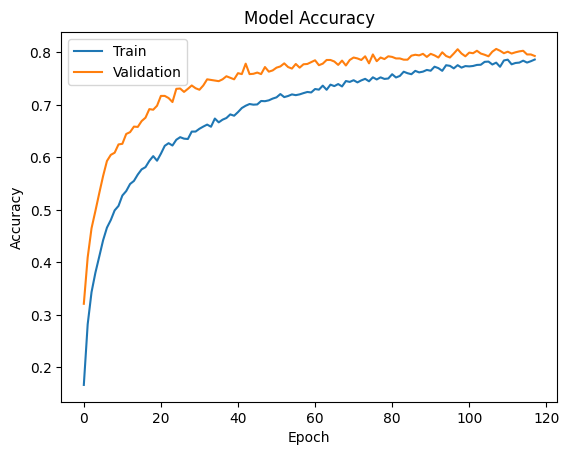

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.constraints import MaxNorm

# Assuming X_mon_features and y are your features and labels respectively

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mon_features)

# Convert labels to categorical (one-hot encoding)
y_categorical = to_categorical(y_mon)

# Split the data into training and testing sets, with shuffling
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.1, shuffle=True, random_state=42)

# Lower the dropout rate to reduce generalization
dropout_rate = 0.3  # Lowered dropout rate

# Define the optimizer with a modified learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

# Add MaxNorm weight constraint
weight_constraint = MaxNorm(max_value=4, axis=0)

# Define the model with different architecture and complexity
model = Sequential([
    Dense(1024, input_dim=X_train.shape[1], kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(768, kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(512, kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(256, kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(y_categorical.shape[1], activation='softmax')
])

# Compile the model with the adjusted optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback with decreased patience to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model with an adjusted batch size and validation split
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,  # Adjusted batch size
    validation_split=0.1,  # Slightly reduced validation split
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Open World:

## Data Preparation:

In [ ]:
import numpy as np


# Create labels for monitored data
y_mon_ones = np.ones(len(X1_mon))

# Create labels for unmonitored data, filled with 95
y_unmon_ninety_fives = np.full(len(X1_unmon), 95)

# Combine the datasets
X1_combined = np.concatenate((X1_mon, X1_unmon), axis=0)
X2_combined = np.concatenate((X2_mon, X2_unmon), axis=0)

# Combine the labels
y_unmon_binary = np.concatenate((y_mon_ones, y_unmon_ninety_fives), axis=0)
y_unmon = np.concatenate((y_mon, y_unmon_ninety_fives), axis=0)


In [ ]:
import numpy as np
import statistics

# Packet Direction and Size Analysis
incoming_packet_count = [sum(1 for size in sub_array if size < 0) for sub_array in X2_combined]  # Incoming Packet Count
outgoing_packet_count = [sum(1 for size in sub_array if size > 0) for sub_array in X2_combined]  # Outgoing Packet Count
total_packet_count = [len(sub_array) for sub_array in X2_combined]  # Total Packet Count
fraction_incoming_packets = [incoming / len(sub_array) if len(sub_array) != 0 else 0 for incoming, sub_array in zip(incoming_packet_count, X2_combined)]  # Fraction of Incoming Packets
fraction_outgoing_packets = [outgoing / len(sub_array) if len(sub_array) != 0 else 0 for outgoing, sub_array in zip(outgoing_packet_count, X2_combined)]  # Fraction of Outgoing Packets

# Packet Ordering Statistics
avg_incoming_packet_order = [np.mean([i for i, size in enumerate(sub_array) if size < 0]) if any(size < 0 for size in sub_array) else 0 for sub_array in X2_combined]  # Avg. Incoming Packet Order
std_dev_incoming_packet_order = [np.std([i for i, size in enumerate(sub_array) if size < 0]) if any(size < 0 for size in sub_array) else 0 for sub_array in X2_combined]  # Std. Dev. Incoming Packet Order
avg_outgoing_packet_order = [np.mean([i for i, size in enumerate(sub_array) if size > 0]) if any(size > 0 for size in sub_array) else 0 for sub_array in X2_combined]  # Avg. Outgoing Packet Order
std_dev_outgoing_packet_order = [np.std([i for i, size in enumerate(sub_array) if size > 0]) if any(size > 0 for size in sub_array) else 0 for sub_array in X2_combined]  # Std. Dev. Outgoing Packet Order

# Packet Concentration and Inter-Arrival Times
packet_concentration = [np.mean(np.diff(time_seq)) if len(time_seq) > 1 else 0 for time_seq in X1_combined]  # Mean Packet Concentration
incoming_inter_arrival_stats = []
outgoing_inter_arrival_stats = []
for time_seq, size_seq in zip(X1_combined, X2_combined):
    if len(time_seq) > 1:
        incoming_times = [time for time, size in zip(time_seq, size_seq) if size < 0]
        outgoing_times = [time for time, size in zip(time_seq, size_seq) if size > 0]
        if incoming_times:
            incoming_diffs = np.diff(incoming_times)
            incoming_inter_arrival_stats.append([np.max(incoming_diffs), np.mean(incoming_diffs), np.std(incoming_diffs), np.percentile(incoming_diffs, 75)])
        else:
            incoming_inter_arrival_stats.append([0, 0, 0, 0])
        if outgoing_times:
            outgoing_diffs = np.diff(outgoing_times)
            outgoing_inter_arrival_stats.append([np.max(outgoing_diffs), np.mean(outgoing_diffs), np.std(outgoing_diffs), np.percentile(outgoing_diffs, 75)])
        else:
            outgoing_inter_arrival_stats.append([0, 0, 0, 0])
    else:
        incoming_inter_arrival_stats.append([0, 0, 0, 0])
        outgoing_inter_arrival_stats.append([0, 0, 0, 0])
incoming_max_inter_arrival_time, incoming_mean_inter_arrival_time, incoming_std_inter_arrival_time, incoming_third_quartile_inter_arrival_time = zip(*incoming_inter_arrival_stats)
outgoing_max_inter_arrival_time, outgoing_mean_inter_arrival_time, outgoing_std_inter_arrival_time, outgoing_third_quartile_inter_arrival_time = zip(*outgoing_inter_arrival_stats)

# Transmission Time Analysis
transmission_time_stats = [[np.percentile(time_seq, q) for q in [25, 50, 75, 100]] for time_seq in X1_combined]  # Quartiles of Transmission Times
transmission_time_Q1, transmission_time_Q2, transmission_time_Q3, transmission_time_Q4 = zip(*transmission_time_stats)

# Packet Count in First 30
incoming_packets_first30 = [sum(1 for size in sub_array[:30] if size < 0) for sub_array in X2_combined]  # Incoming Packets in First 30
outgoing_packets_first30 = [sum(1 for size in sub_array[:30] if size > 0) for sub_array in X2_combined]  # Outgoing Packets in First 30

# Packet Per Second Analysis
packets_per_second_stats = [[np.mean(np.diff(time_seq)), np.std(np.diff(time_seq)), np.median(np.diff(time_seq))] if len(time_seq) > 1 else [0, 0, 0] for time_seq in X1_combined]
mean_packets_per_second, std_packets_per_second, median_packets_per_second = zip(*packets_per_second_stats)

# Alternative Packets Per Second Sum
alternative_packets_per_second_sum = [sum(np.diff(time_seq)) for time_seq in X1_combined]  # Alternative Packets Per Second Sum
combined_counts = [incoming + outgoing + total for incoming, outgoing, total in zip(incoming_packet_count, outgoing_packet_count, total_packet_count)]

# Additional Features
sum_packet_sizes = [sum(abs(size) for size in sub_array) for sub_array in X2_combined]  # Sum of Packet Sizes
mean_sequence_value = [np.mean(sub_array) for sub_array in X2_combined]  # Mean of the Sequence

max_packet_size = [max(sub_array, default=0) for sub_array in X2_combined]  # Max Packet Size for each time series

average_packet_size = [np.mean([abs(size) for size in sub_array]) if sub_array else 0 for sub_array in X2_combined]  # Average Packet Size for each time series
peak_to_average_packet_ratio = [max_size / avg_size if avg_size != 0 else 0 for max_size, avg_size in zip(max_packet_size, average_packet_size)]  # Peak to Average Packet Ratio for each time series

max_time_interval = [max(np.diff(time_seq), default=0) for time_seq in X1_combined]  # Max Time Interval for each time series

std_dev_transmission_times = [np.std(np.diff(time_seq)) if len(time_seq) > 1 else 0 for time_seq in X1_combined]

small_packet_threshold = 513  # Define the threshold for small packets
percentage_small_packets = [sum(1 for size in sub_array if abs(size) < small_packet_threshold) / len(sub_array) * 100 if sub_array else 0 for sub_array in X2_combined]  # Percentage of Small Packets for each time series

In [ ]:
feature_names = [
    "Incoming Packet Count",
    "Outgoing Packet Count",
    "Total Packet Count",
    "Fraction of Incoming Packets",
    "Fraction of Outgoing Packets",
    "Average Incoming Packet Order",
    "Standard Deviation of Incoming Packet Order",
    "Average Outgoing Packet Order",
    "Standard Deviation of Outgoing Packet Order",
    "Mean Packet Concentration",
    "Maximum Incoming Inter-Arrival Time",
    "Mean Incoming Inter-Arrival Time",
    "Standard Deviation of Incoming Inter-Arrival Time",
    #"Third Quartile of Incoming Inter-Arrival Time",
    "Maximum Outgoing Inter-Arrival Time",
    "Mean Outgoing Inter-Arrival Time",
    "Standard Deviation of Outgoing Inter-Arrival Time",
    "Third Quartile of Outgoing Inter-Arrival Time",
    "First Quartile of Transmission Time",
    "Second Quartile of Transmission Time",
    "Third Quartile of Transmission Time",
    "Fourth Quartile of Transmission Time",
    "Incoming Packets in First 30",
    "Outgoing Packets in First 30",
    "Mean Packets Per Second",
    "Standard Deviation of Packets Per Second",
    #"Median Packets Per Second",
    "Alternative Packets Per Second Sum",
    "Combined Packet Count",
    "Sum of Packet Sizes",
    "Mean of Packet Sizes",
    #"Maximum Packet Size",
    #"Peak to Average Packet Size Ratio",
    "Maximum Time Interval",
    "Standard Deviation of Transmission Times",
    #"Percentage of Small Packets"
]

X_unmon_features = np.column_stack((
    incoming_packet_count,
    outgoing_packet_count,
    total_packet_count,
    fraction_incoming_packets,
    fraction_outgoing_packets,
    avg_incoming_packet_order,
    std_dev_incoming_packet_order,
    avg_outgoing_packet_order,
    std_dev_outgoing_packet_order,
    packet_concentration,
    incoming_max_inter_arrival_time,
    incoming_mean_inter_arrival_time,
    incoming_std_inter_arrival_time,
    #incoming_third_quartile_inter_arrival_time,
    outgoing_max_inter_arrival_time,
    outgoing_mean_inter_arrival_time,
    outgoing_std_inter_arrival_time,
    outgoing_third_quartile_inter_arrival_time,
    transmission_time_Q1,
    transmission_time_Q2,
    transmission_time_Q3,
    transmission_time_Q4,
    incoming_packets_first30,
    outgoing_packets_first30,
    mean_packets_per_second,
    std_packets_per_second,
    #median_packets_per_second,
    alternative_packets_per_second_sum,
    combined_counts,
    sum_packet_sizes,
    mean_sequence_value,
    #max_packet_size,
    #peak_to_average_packet_ratio,
    max_time_interval,
    std_dev_transmission_times,
    #percentage_small_packets
))

## Open World Binary Class:

### Logistic Regression:

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'logistic__C': 0.01, 'logistic__max_iter': 1000, 'logistic__solver': 'liblinear', 'pca__n_components': 15}
Accuracy: 0.7279
ROC AUC: 0.7229
Precision: 0.7388
Recall: 0.9066
F1-Score: 0.8142

Detailed Classification Report:

              precision    recall  f1-score   support

         1.0       0.74      0.91      0.81      5719
        95.0       0.68      0.39      0.49      2981

    accuracy                           0.73      8700
   macro avg       0.71      0.65      0.65      8700
weighted avg       0.72      0.73      0.70      8700



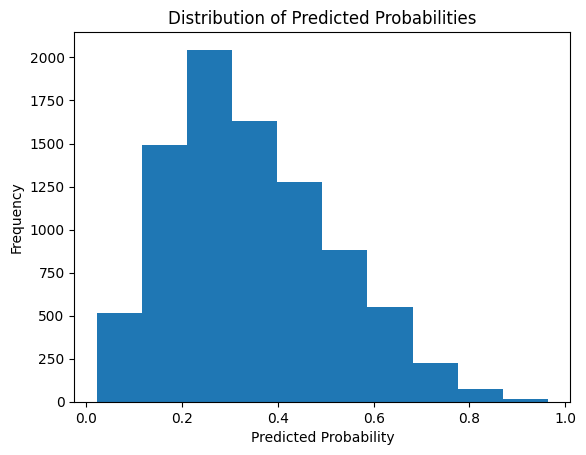

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# Assuming X_unmon_features and y_unmon_binary are already defined and are your dataset

# Split the combined dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_unmon_features, y_unmon_binary, test_size=0.3, random_state=42)

# Create a pipeline that standardizes, then runs PCA, then fits LogisticRegression
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('logistic', LogisticRegression())
])

# Set the parameters for grid search
param_grid = {
    'pca__n_components': [5, 10, 15, 20, 25],
    'logistic__C': [0.01, 0.1, 1, 10, 100],
    'logistic__solver': ['lbfgs', 'liblinear'],
    'logistic__max_iter': [1000]  # Increase max_iter to ensure convergence
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, verbose=1, n_jobs=-1)

# Train the model with grid search
grid_search.fit(X_train, y_train)

# Best estimator found by grid search
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model found by grid search
y_pred = grid_search.predict(X_test)
y_pred_probs = grid_search.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate different metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print out the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Generate a detailed classification report
print("\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred))

# It's a good practice to check the distribution of predicted probabilities
import matplotlib.pyplot as plt
plt.hist(y_pred_probs, bins=10)
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

### Naive Bayes

Accuracy: 0.7330
ROC AUC: 0.7566
Precision: 0.7383
Recall: 0.9197
F1-Score: 0.8191

Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.37      0.49      2981
           1       0.74      0.92      0.82      5719

    accuracy                           0.73      8700
   macro avg       0.72      0.65      0.65      8700
weighted avg       0.73      0.73      0.71      8700



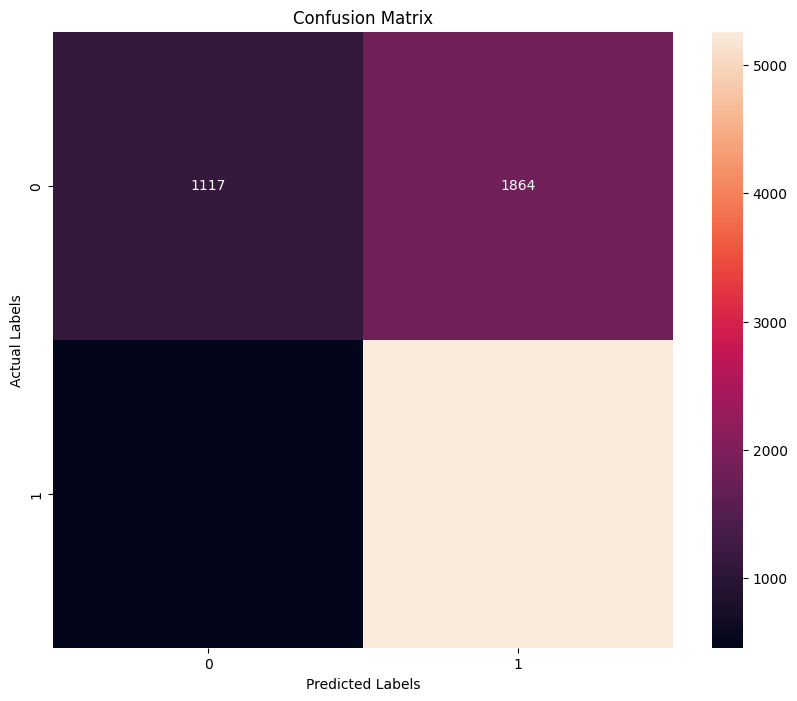

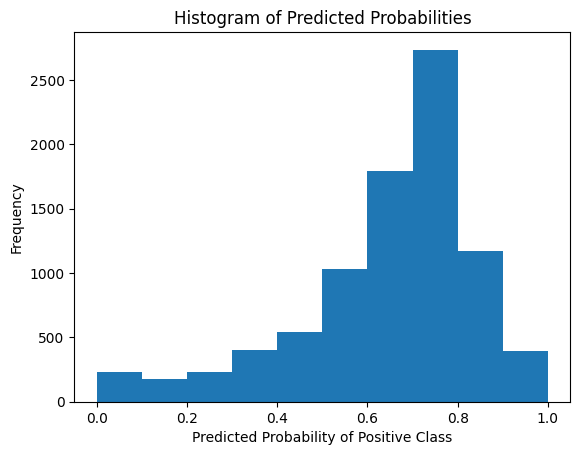

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_unmon_features and y_unmon_binary are your features and labels respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_unmon_features, y_unmon_binary, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Adjust the component number based on your dataset
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the classifier on the transformed data
gnb.fit(X_train_pca, y_train)

# Make predictions on the transformed test data
y_pred = gnb.predict(X_test_pca)
y_pred_probs = gnb.predict_proba(X_test_pca)[:, 1]

# Calculate accuracy and other performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Output the results
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Generate and print a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Histogram of predicted probabilities
plt.hist(y_pred_probs, bins=10)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

### SVM:

Accuracy: 0.7784
ROC AUC: 0.8492
Precision: 0.7837
Recall: 0.9155
F1-Score: 0.8445

Classification Report:

              precision    recall  f1-score   support

         1.0       0.78      0.92      0.84      5719
        95.0       0.76      0.52      0.61      2981

    accuracy                           0.78      8700
   macro avg       0.77      0.72      0.73      8700
weighted avg       0.78      0.78      0.77      8700



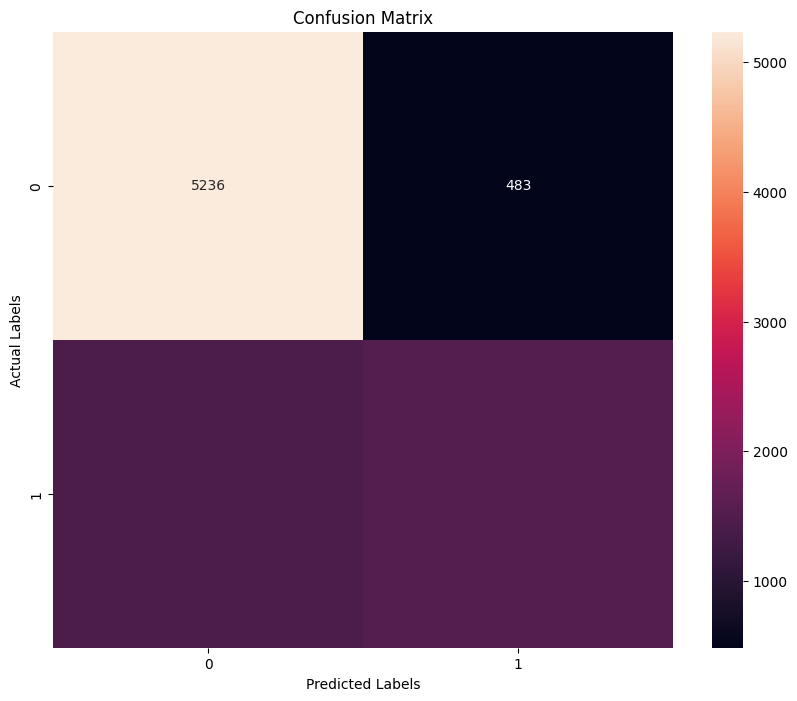

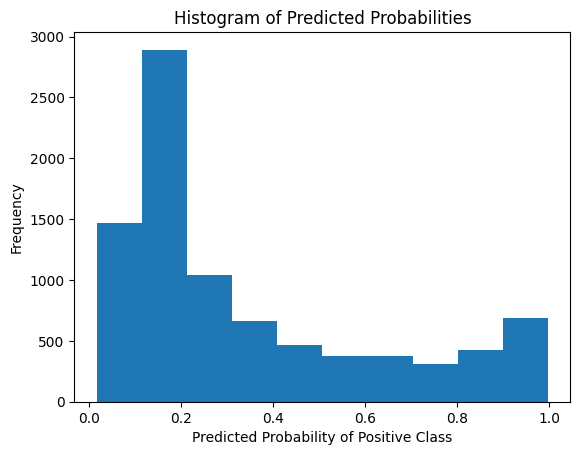

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_unmon_features and y_unmon_binary are your features and labels respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_unmon_features, y_unmon_binary, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Adjust the number of components based on your dataset
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Initialize the Support Vector Classifier
# The 'C' parameter is a regularization parameter and can be tuned for better performance
svm_clf = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True)

# Train the classifier on the transformed data
svm_clf.fit(X_train_pca, y_train)

# Make predictions on the transformed test data
y_pred = svm_clf.predict(X_test_pca)
y_pred_probs = svm_clf.predict_proba(X_test_pca)[:, 1]  # Probability estimates

# Calculate accuracy and other performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Output the results
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Generate and print a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Histogram of predicted probabilities
plt.hist(y_pred_probs, bins=10)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Frequency')
plt.show()

### Decision Tree:

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.7926
Precision: 0.8343
Recall: 0.8542
F1-Score: 0.8441

Classification Report:

              precision    recall  f1-score   support

        -1.0       0.71      0.67      0.69      2981
         1.0       0.83      0.85      0.84      5719

    accuracy                           0.79      8700
   macro avg       0.77      0.76      0.77      8700
weighted avg       0.79      0.79      0.79      8700



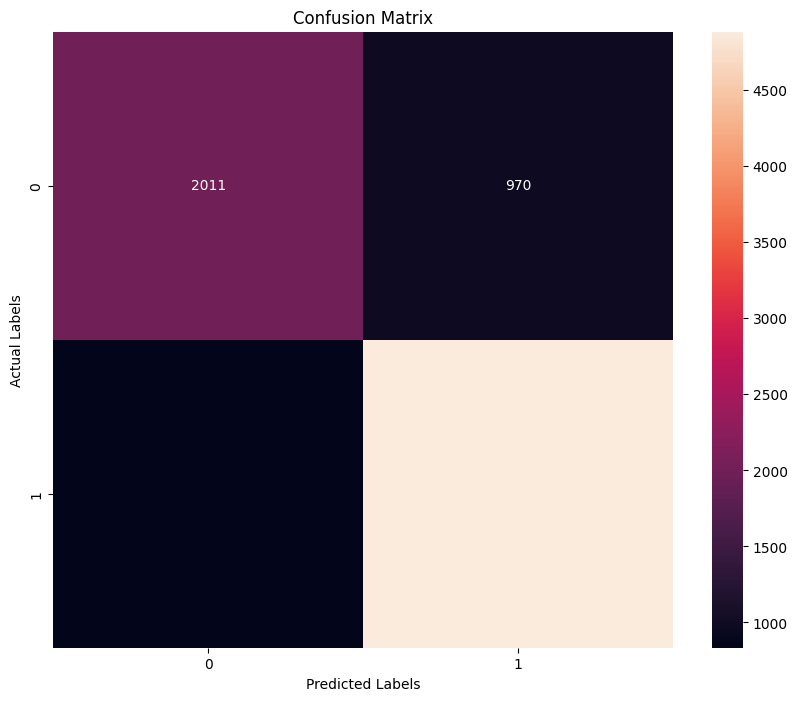

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_unmon_features and y_unmon_binary are your features and labels respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_unmon_features, y_unmon_binary, test_size=0.3, random_state=42)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Set up the grid of parameters to search
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(dt_clf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train the classifier with best parameters
best_dt_clf = grid_search.best_estimator_

# Make predictions
y_pred = best_dt_clf.predict(X_test)

# Calculate accuracy and other performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Since Decision Trees don't predict probabilities, we cannot calculate the ROC AUC directly
# If you still want to calculate ROC AUC, you'll have to modify the model to predict probabilities

# Output the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Generate and print a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Visualizing the Decision Tree
#plt.figure(figsize=(20, 10))
#plot_tree(best_dt_clf, filled=True, feature_names=feature_names, class_names=['Class 0', 'Class 1'])
#plt.title('Decision Tree')
#plt.show()

### Random Forest Classifier:

Accuracy: 0.8601
Precision: 0.8558
Recall: 0.8276
F1-Score: 0.8388

Classification Report:

              precision    recall  f1-score   support

        -1.0       0.85      0.72      0.78      2981
         1.0       0.87      0.93      0.90      5719

    accuracy                           0.86      8700
   macro avg       0.86      0.83      0.84      8700
weighted avg       0.86      0.86      0.86      8700



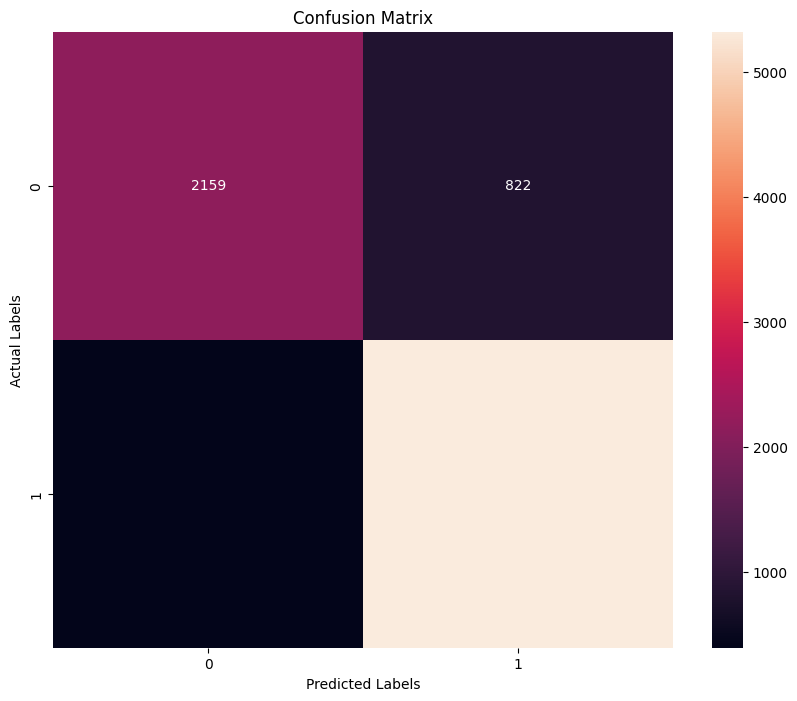

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_unmon_features, y_unmon_binary, test_size=0.3, random_state=42)

# Initialize the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=1000,
    criterion='entropy',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1
)

# Fit the classifier to the training data
clf.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_scaled)

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Generate and print a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

### k-NN Classifier:

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameter found:  {'n_neighbors': 7}
Accuracy: 0.8155

Classification Report:

              precision    recall  f1-score   support

        -1.0       0.79      0.62      0.70      2981
         1.0       0.82      0.92      0.87      5719

    accuracy                           0.82      8700
   macro avg       0.81      0.77      0.78      8700
weighted avg       0.81      0.82      0.81      8700



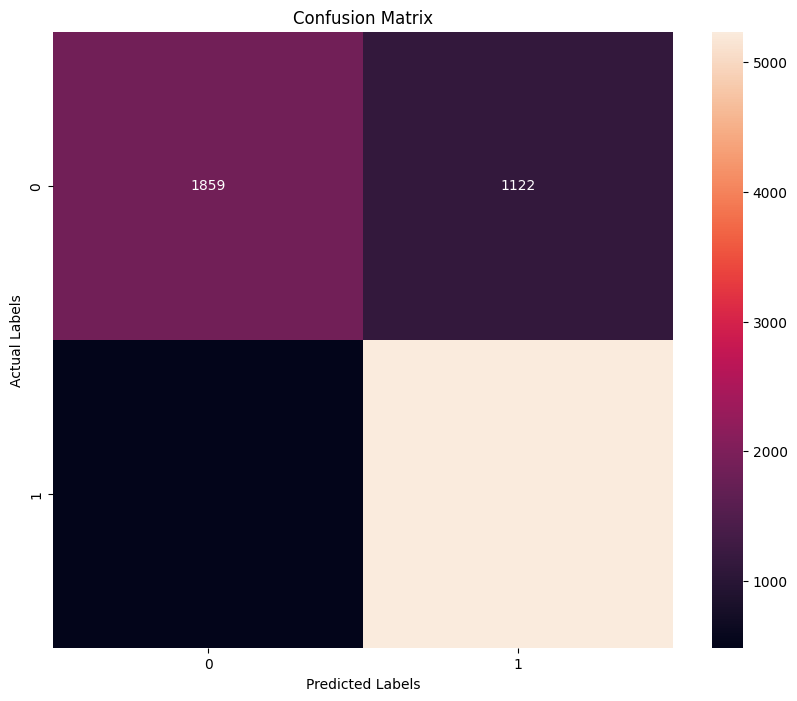

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_unmon_features, y_unmon_binary, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Set up the grid of parameters to search
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Initialize the k-NN Classifier and GridSearchCV
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, n_jobs=-1, verbose=1)

# Train the model with grid search
grid_search.fit(X_train_pca, y_train)

# Best parameter
print("Best parameter found: ", grid_search.best_params_)

# Train the classifier with the best number of neighbors
best_knn_clf = grid_search.best_estimator_

# Make predictions
y_pred = best_knn_clf.predict(X_test_pca)

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Calculate ROC AUC score if y is binary
# roc_auc = roc_auc_score(y_test, best_knn_clf.predict_proba(X_test_pca)[:, 1])
# print(f'ROC AUC Score: {roc_auc:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

### DB-Scan:

Accuracy of DBSCAN clustering: 0.6180
[[8588 1412]
 [9666 9334]]


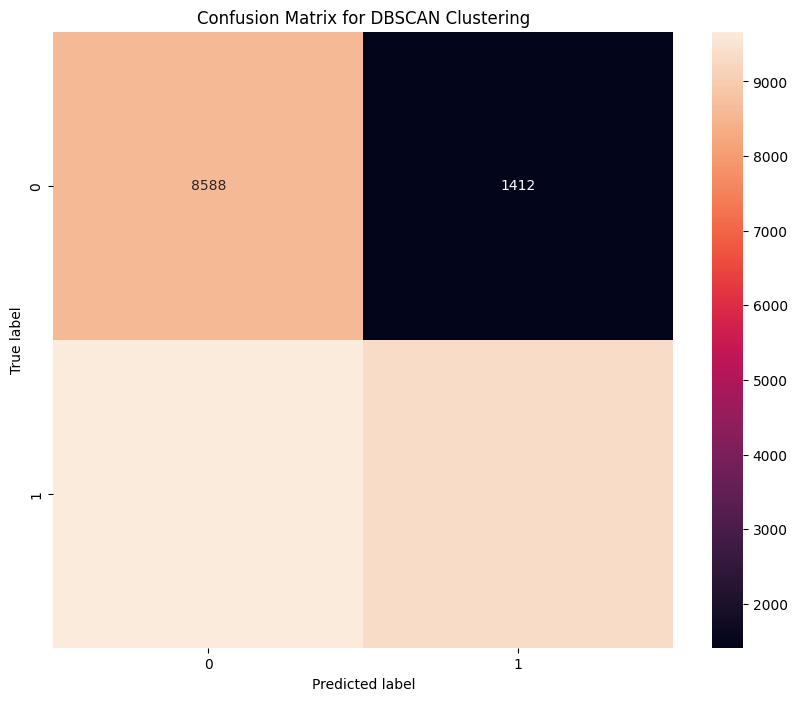

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Scaling and PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unmon_features)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_pca)

# Assigning labels to clusters
labels_pred = np.zeros_like(clusters)
for cluster in np.unique(clusters):
    if cluster != -1:  # Ignore noise points
        mask = (clusters == cluster)
        # Assign 1 if the majority of points in the cluster have a label of 1, else -1
        labels_pred[mask] = 1 if np.mean(y_unmon_binary[mask]) > 0 else -1

# Handling noise points: assigning -1 to noise points
labels_pred[clusters == -1] = -1

# Computing the accuracy
accuracy = accuracy_score(y_unmon_binary, labels_pred)
print(f'Accuracy of DBSCAN clustering: {accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_unmon_binary, labels_pred)
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix for DBSCAN Clustering')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### k-Means:

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Best parameters found:  {'n_clusters': 9}


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy of KMeans clustering: 0.6646

Classification Report:

              precision    recall  f1-score   support

        -1.0       0.56      0.13      0.21     10000
         1.0       0.67      0.95      0.79     19000

    accuracy                           0.66     29000
   macro avg       0.62      0.54      0.50     29000
weighted avg       0.63      0.66      0.59     29000



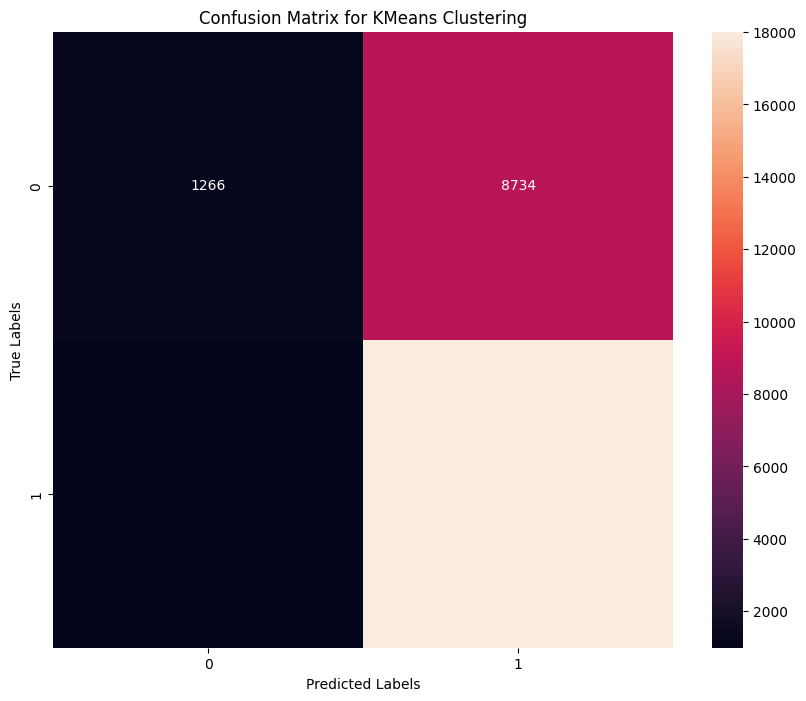

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore specific types of warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unmon_features)

# PCA
pca = PCA(n_components=0.95)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

# Grid Search for KMeans
param_grid = {
    'n_clusters': range(2, 10)  # Adjust the range based on the expected number of clusters
}

kmeans = KMeans(random_state=42)
grid_search = GridSearchCV(kmeans, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_pca)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train KMeans with the best number of clusters
best_kmeans = grid_search.best_estimator_
clusters = best_kmeans.fit_predict(X_pca)

# Assigning labels based on the mode
labels_pred = np.zeros_like(clusters)
for cluster in np.unique(clusters):
    mask = (clusters == cluster)
    labels_pred[mask] = mode(y_unmon_binary[mask])[0]

# Compute accuracy
accuracy = accuracy_score(y_unmon_binary, labels_pred)
print(f'Accuracy of KMeans clustering: {accuracy:.4f}')

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_unmon_binary, labels_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_unmon_binary, labels_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix for KMeans Clustering')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Neuronal Network:

[ 1.  1.  1. ... -1. -1. -1.]
Epoch 1/150
368/368 [==============================] - 8s 16ms/step - loss: 0.5482 - accuracy: 0.7382 - val_loss: 0.4646 - val_accuracy: 0.7739
Epoch 2/150
368/368 [==============================] - 6s 15ms/step - loss: 0.4893 - accuracy: 0.7643 - val_loss: 0.4561 - val_accuracy: 0.7808
Epoch 3/150
368/368 [==============================] - 6s 16ms/step - loss: 0.4761 - accuracy: 0.7707 - val_loss: 0.4616 - val_accuracy: 0.7755
Epoch 4/150
368/368 [==============================] - 5s 15ms/step - loss: 0.4714 - accuracy: 0.7727 - val_loss: 0.4597 - val_accuracy: 0.7801
Epoch 5/150
368/368 [==============================] - 5s 15ms/step - loss: 0.4618 - accuracy: 0.7762 - val_loss: 0.4419 - val_accuracy: 0.7923
Epoch 6/150
368/368 [==============================] - 6s 16ms/step - loss: 0.4633 - accuracy: 0.7788 - val_loss: 0.4446 - val_accuracy: 0.7824
Epoch 7/150
368/368 [==============================] - 6s 15ms/step - loss: 0.4588 - accuracy: 0.7790 - va

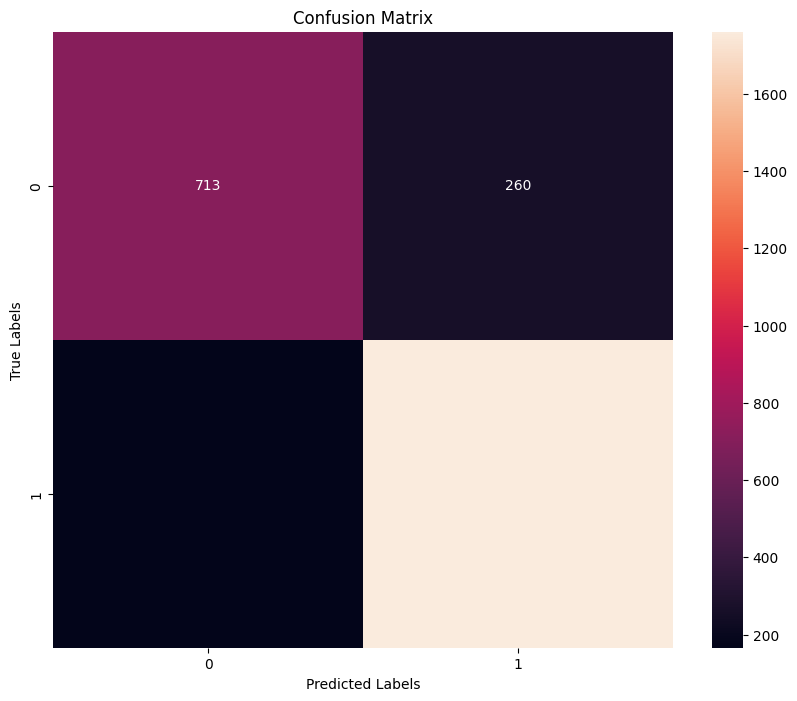

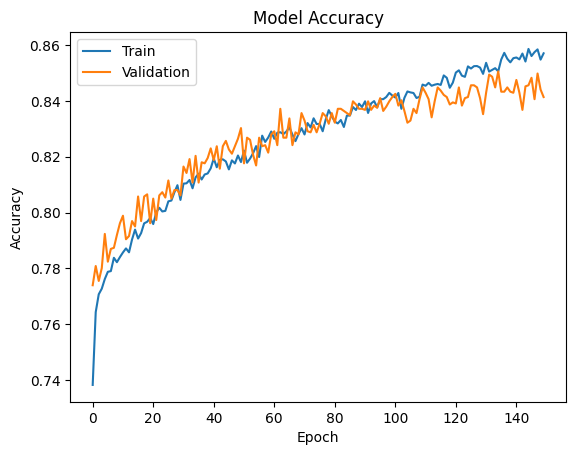

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.constraints import MaxNorm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unmon_features)

# Convert labels to categorical (one-hot encoding)
y_mapped = np.where(y_unmon_binary == 95, 0, 1)

# Convert mapped labels to categorical (one-hot encoding)
y_categorical = to_categorical(y_mapped)

# Split the data into training and testing sets, with shuffling
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.1, shuffle=True, random_state=42)

# Lower the dropout rate to reduce generalization
dropout_rate = 0.3  # Lowered dropout rate

# Define the optimizer with a modified learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

# Add MaxNorm weight constraint
weight_constraint = MaxNorm(max_value=4, axis=0)

# Define the model with different architecture and complexity
model = Sequential([
    Dense(1024, input_dim=X_train.shape[1], kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(768, kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(512, kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(256, kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(y_categorical.shape[1], activation='softmax')
])

# Compile the model with the adjusted optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback with decreased patience to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model with an adjusted batch size and validation split
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,  # Adjusted batch size
    validation_split=0.1,  # Slightly reduced validation split
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
